### Keypoints
- spectral
- geomap

# Spectral Analysis using xrft and Pangeo

In [2]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader # use this to convert from faces to lat-lon format. 
from matplotlib import pyplot as plt
import xgcm

%matplotlib inline

In [1]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
# Use intake to access the LLC4320 catalog
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.open_catalog(cat_url)

In [4]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [ ]:
ds = xr.merge([ssh, sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
# I believe that converting data to latlon slows things down quite a bit. 
# So for speeding things up try to stick with directly analyzing face. 

In [ ]:
ds

In [ ]:
# The LLC grid is part of this catalog
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords

In [ ]:
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
coords

In [9]:
coords.XC

<xarray.DataArray 'XC' (j: 12960, i: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Attributes:
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [10]:
np.logical_and(coords.XC>25, coords.XC<45 ) # 仅仅是逻辑运算符，内部是TRUE或者FALSE

<xarray.DataArray 'XC' (j: 12960, i: 17280)>
dask.array<logical_and, shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [11]:
tmp=np.logical_and(coords.XC>25, coords.XC<45 ).to_numpy()
tmp

[########################################] | 100% Completed | 930.43 ms


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [12]:
# pick a region that is not too close to the poles, here the grid 
# is approximately squarish
sel_area = np.logical_and(np.logical_and(coords.XC>25, coords.XC<45 ),
                           np.logical_and(coords.YC>-55, coords.YC<-49 ))
# sel_area.to_numpy()
# 

In [13]:
sel_area

<xarray.DataArray 'XC' (j: 12960, i: 17280)>
dask.array<logical_and, shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [14]:
# Setup grid object for calculus on variables
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [15]:
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

In [16]:
# X = coords.XC.where(sel_area, drop=True) # very slow. Stuck here
X=coords.XC.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1))

In [17]:
X

<xarray.DataArray 'XC' (j: 2817, i: 2879)>
dask.array<getitem, shape=(2817, 2879), dtype=float32, chunksize=(2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
Attributes:
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [18]:
# Y = coords.YC.where(sel_area, drop=True)
Y=coords.YC.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1))

In [19]:
Y

<xarray.DataArray 'YC' (j: 2817, i: 2879)>
dask.array<getitem, shape=(2817, 2879), dtype=float32, chunksize=(2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
Attributes:
    coordinate:     YC XC
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [20]:
Xmean = X.mean(['j'])
Ymean = Y.mean(['i']) # make some approximate X, Y coordinates (we chose a region with approx square grids)

In [21]:
Xmean

<xarray.DataArray 'XC' (i: 2879)>
dask.array<mean_agg-aggregate, shape=(2879,), dtype=float32, chunksize=(2496,), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702

In [22]:
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,27 Graph Layers,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,27 Graph Layers,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [23]:
# i=slice(1824, 4703,1),j=slice(4040,6857,1) 使用ij的切片筛选数据最快

In [24]:
# SSH_sel = ds.Eta.where(sel_area, drop=True)
# SST_sel = ds.SST.where(sel_area, drop=True)

SSH_sel = ds.Eta.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1), drop=True)
SST_sel = ds.SST.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1), drop=True)

In [25]:
SST_sel

<xarray.DataArray 'SST' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [26]:
# SSS_sel = ds.SSS.where(sel_area, drop=True)
SSS_sel = ds.SSS.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1), drop=True)

In [27]:
# U_sel = (grid.interp(ds.U, 'X', boundary='extend')).where(sel_area, drop=True).rename('U')
# V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).where(sel_area, drop=True).rename('V')

U_sel = (grid.interp(ds.U, 'X', boundary='extend')).isel(i=slice(1824, 4703,1),j=slice(4040,6857,1), drop=True).rename('U')
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).isel(i=slice(1824, 4703,1),j=slice(4040,6857,1), drop=True).rename('V')

In [28]:
U_sel

<xarray.DataArray 'U' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [29]:
# calculate surface density
from fastjmd95 import rho
SSD_sel = xr.apply_ufunc(rho, 
                        SSS_sel, SST_sel, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [30]:
SSD_sel

<xarray.DataArray 'SSD' (time: 9030, j: 2817, i: 2879)>
dask.array<transpose, shape=(9030, 2817, 2879), dtype=float64, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [31]:
Xmean

<xarray.DataArray 'XC' (i: 2879)>
dask.array<mean_agg-aggregate, shape=(2879,), dtype=float32, chunksize=(2496,), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702

In [32]:
# ds_sel = xr.merge([SSH_sel, SST_sel, SSS_sel, U_sel, V_sel, SSD_sel]
#                  ).assign_coords(XC=Xmean, YC=Ymean)
ds_sel = xr.merge([SSH_sel, SST_sel, SSS_sel, U_sel, V_sel, SSD_sel]
                 ).assign_coords(XC=Xmean, YC=Ymean) # .assign_coords(XC=Xmean, YC=Ymean) 是添加坐标轴

In [33]:
ds_sel

<xarray.Dataset>
Dimensions:  (i: 2879, j: 2817, time: 9030)
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC       (i) float32 dask.array<chunksize=(2496,), meta=np.ndarray>
    YC       (j) float32 dask.array<chunksize=(280,), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>
    U        (time, j, i) float32 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>
    V        (time, j, i) float32 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>
    SSD      (time, j, i) float64 dask.array<chunksize=(1, 280, 2496), meta=np.ndarray>

In [34]:
# Load a single time step so that plotting is faster
ds_sel_loaded =  ds_sel.isel(time=0)
%time ds_sel_loaded.load();

[########################################] | 100% Completed | 3.05 sms
CPU times: user 17.7 s, sys: 3.66 s, total: 21.3 s
Wall time: 15.7 s


<xarray.Dataset>
Dimensions:  (i: 2879, j: 2817)
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
    XC       (i) float32 0.01042 0.03125 0.05208 0.07292 ... 59.93 59.95 59.97
    YC       (j) float32 -60.0 -59.99 -59.98 -59.97 ... -20.07 -20.05 -20.03
Data variables:
    Eta      (j, i) float32 -2.128 -2.13 -2.131 -2.131 ... 0.4445 0.4459 0.4475
    SST      (j, i) float32 -1.873 -1.873 -1.874 -1.874 ... 22.87 22.87 22.86
    SSS      (j, i) float32 34.21 34.21 34.21 34.21 ... 35.25 35.27 35.28 35.29
    U        (j, i) float32 -0.03118 -0.03053 -0.02989 ... -0.1109 -0.1127
    V        (j, i) float32 0.1712 0.1727 0.1742 ... -0.1241 -0.1059 -0.08785
    SSD      (j, i) float64 1.028e+03 1.028e+03 ... 1.024e+03 1.024e+03

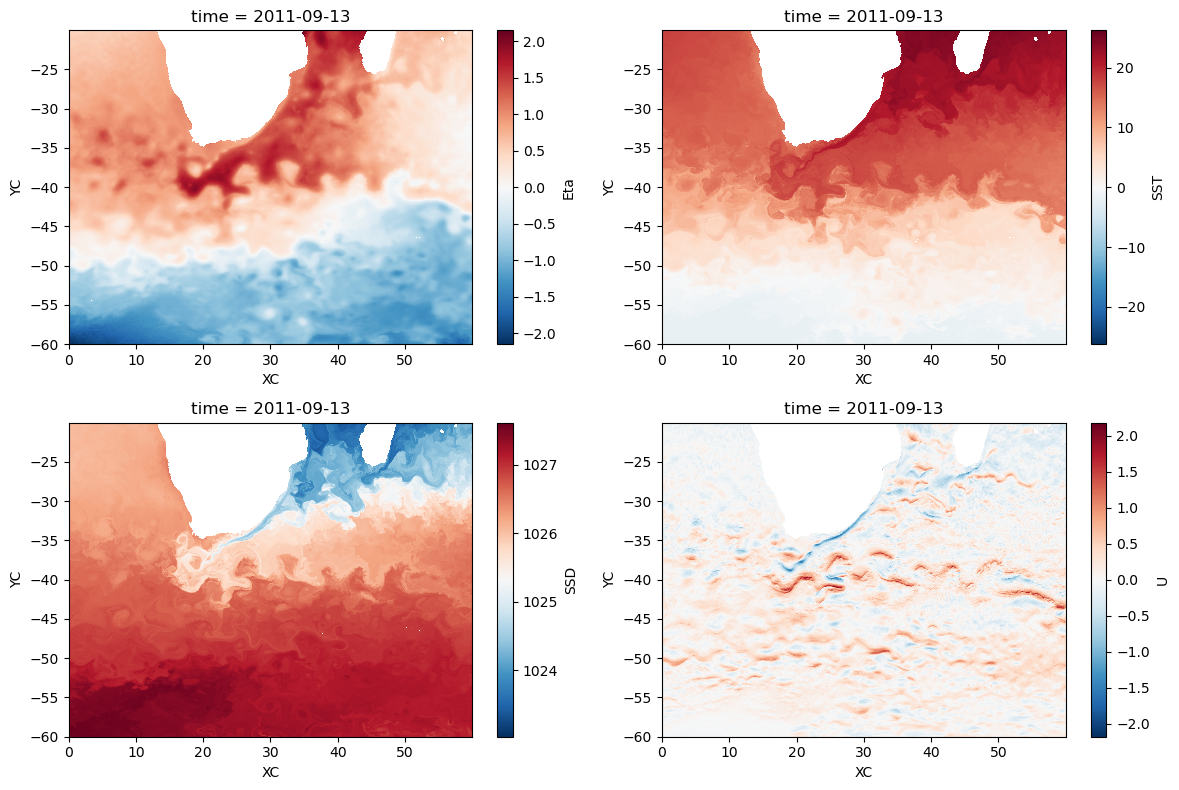

In [35]:
# Some maps 

plt.figure(figsize=(12,8))

plt.subplot(221)
ds_sel_loaded.Eta.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(222)
ds_sel_loaded.SST.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(223)
ds_sel_loaded.SSD.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(224)
ds_sel_loaded.U.plot(x='XC', y='YC', cmap='RdBu_r')

plt.tight_layout()

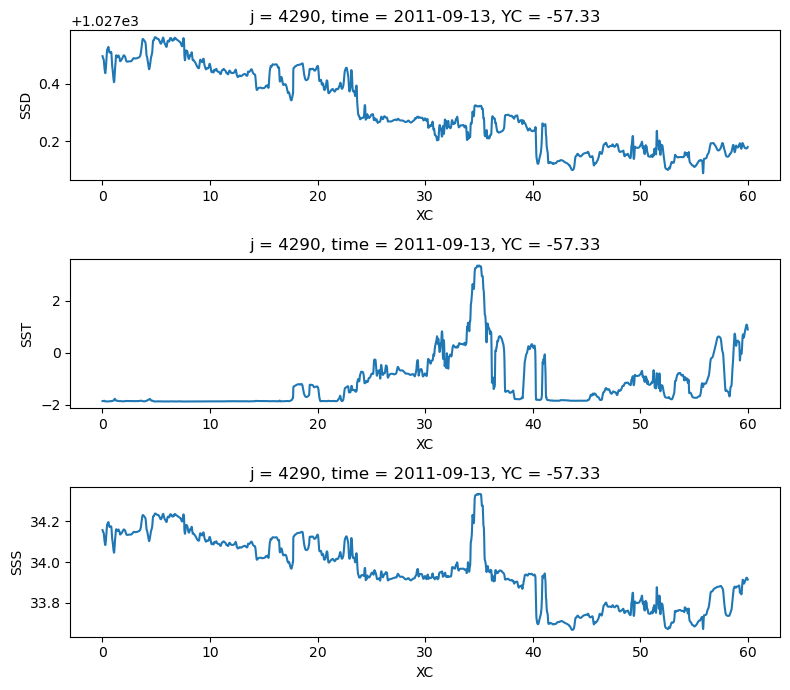

In [36]:
# Some 1D section to see the structure in the data 
plt.figure(figsize=(8,7))
plt.subplot(311)
ds_sel_loaded.SSD.isel(j=250).plot(x='XC' )

plt.subplot(312)
ds_sel_loaded.SST.isel(j=250).plot(x='XC' )

plt.subplot(313)
ds_sel_loaded.SSS.isel(j=250).plot(x='XC' )

plt.tight_layout()

In [37]:
ds_sel_loaded

<xarray.Dataset>
Dimensions:  (i: 2879, j: 2817)
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
    XC       (i) float32 0.01042 0.03125 0.05208 0.07292 ... 59.93 59.95 59.97
    YC       (j) float32 -60.0 -59.99 -59.98 -59.97 ... -20.07 -20.05 -20.03
Data variables:
    Eta      (j, i) float32 -2.128 -2.13 -2.131 -2.131 ... 0.4445 0.4459 0.4475
    SST      (j, i) float32 -1.873 -1.873 -1.874 -1.874 ... 22.87 22.87 22.86
    SSS      (j, i) float32 34.21 34.21 34.21 34.21 ... 35.25 35.27 35.28 35.29
    U        (j, i) float32 -0.03118 -0.03053 -0.02989 ... -0.1109 -0.1127
    V        (j, i) float32 0.1712 0.1727 0.1742 ... -0.1241 -0.1059 -0.08785
    SSD      (j, i) float64 1.028e+03 1.028e+03 ... 1.024e+03 1.024e+03

In [38]:
ds_sel_loaded=ds_sel_loaded.drop(['XC','YC'])

In [39]:
# ds_sel_loaded=ds_sel_loaded.drop(['YC'])

In [40]:
ds_sel_loaded

<xarray.Dataset>
Dimensions:  (i: 2879, j: 2817)
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 -2.128 -2.13 -2.131 -2.131 ... 0.4445 0.4459 0.4475
    SST      (j, i) float32 -1.873 -1.873 -1.874 -1.874 ... 22.87 22.87 22.86
    SSS      (j, i) float32 34.21 34.21 34.21 34.21 ... 35.25 35.27 35.28 35.29
    U        (j, i) float32 -0.03118 -0.03053 -0.02989 ... -0.1109 -0.1127
    V        (j, i) float32 0.1712 0.1727 0.1742 ... -0.1241 -0.1059 -0.08785
    SSD      (j, i) float64 1.028e+03 1.028e+03 ... 1.024e+03 1.024e+03

## Power Spectra

### Wavenumber Spectra

In [41]:
# Wavenumber spectra calculated by transforming in the x direction
# 注意，计算的谱是x方向的数据，由于数据是二维网格的，因此最后的谱结果将是和y方向有关的数组。一个y值上面有一条谱。

SSH_k_ps = xrft.power_spectrum(ds_sel_loaded.Eta, 
                               dim=['i'], # 主要这个dim的作用是什么？ The dimensions along which to take the transformation. If None, all dimensions will be transformed.
                               window=True, 
                               detrend='constant')
SST_k_ps = xrft.power_spectrum(ds_sel_loaded.SST, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
SSD_k_ps = xrft.power_spectrum(ds_sel_loaded.SSD, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
U_k_ps = xrft.power_spectrum(ds_sel_loaded.U, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
V_k_ps = xrft.power_spectrum(ds_sel_loaded.V, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')

# here we used only the loaded data from one time step.
# For the spatial power spectra a single snapshot (over some area) is sufficient for the 
# wavenumber spectra to almost converge

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Ple

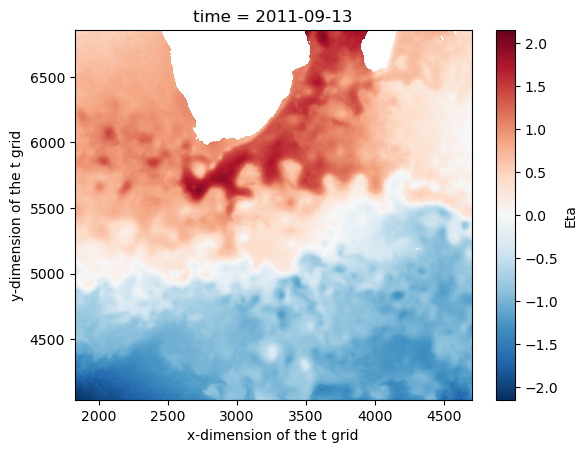

In [42]:
ds_sel_loaded.Eta.plot()

In [67]:
ds_sel_loaded.to_netcdf('feizhou.nc')

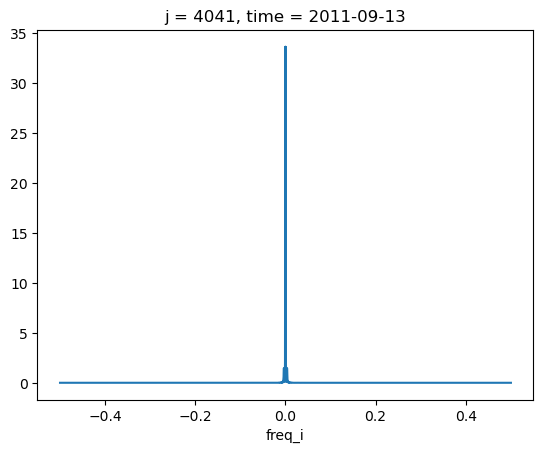

In [43]:
SSH_k_ps.isel(j=1).plot()

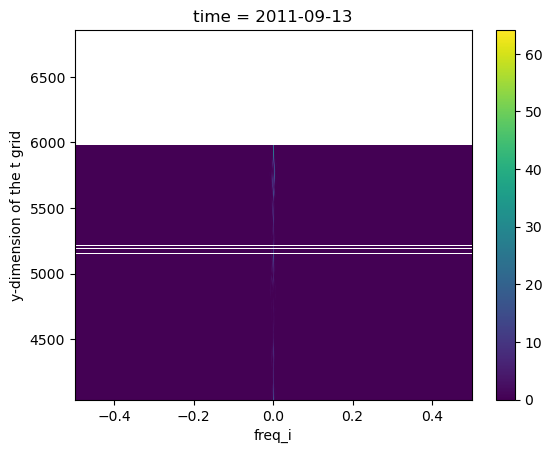

In [44]:
SSH_k_ps.plot()

In [45]:
ds_sel_loaded_k_ps = xr.merge([SSH_k_ps.rename('SSH_ps'),
                               SST_k_ps.rename('SST_ps'), 
                               SSD_k_ps.rename('SSD_ps'),
                               U_k_ps.rename('U_ps'),
                               V_k_ps.rename('V_ps')])

In [62]:
SSH_k_ps

<xarray.DataArray (j: 2817, freq_i: 2879)>
array([[2.66616430e-09, 1.72926909e-08, 1.70847848e-08, ...,
        1.70847848e-08, 1.72926909e-08, 2.66616430e-09],
       [1.26730768e-07, 6.27291721e-08, 8.24821004e-08, ...,
        8.24821004e-08, 6.27291721e-08, 1.26730768e-07],
       [1.52804707e-08, 2.33246327e-09, 1.18012822e-09, ...,
        1.18012822e-09, 2.33246327e-09, 1.52804707e-08],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
  * freq_i   (freq_i) float64 -0.4998 -0.4995 -0.4991 ... 0.4991 0.4995 0.4998

In [47]:
# again load for faster plotting.
%time ds_sel_loaded_k_ps.load()

CPU times: user 112 µs, sys: 0 ns, total: 112 µs
Wall time: 117 µs


<xarray.Dataset>
Dimensions:  (j: 2817, freq_i: 2879)
Coordinates:
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
  * freq_i   (freq_i) float64 -0.4998 -0.4995 -0.4991 ... 0.4991 0.4995 0.4998
Data variables:
    SSH_ps   (j, freq_i) float64 2.666e-09 1.729e-08 1.708e-08 ... nan nan nan
    SST_ps   (j, freq_i) float64 3.181e-05 2.556e-05 1.655e-05 ... nan nan nan
    SSD_ps   (j, freq_i) float64 1.206e-06 9.987e-07 6.832e-07 ... nan nan nan
    U_ps     (j, freq_i) float64 2.168e-13 1.301e-12 1.716e-12 ... nan nan nan
    V_ps     (j, freq_i) float64 2.878e-08 6.962e-08 1.015e-07 ... nan nan nan

Text(0.5, 1.0, 'Power Spectra of Different Variables')

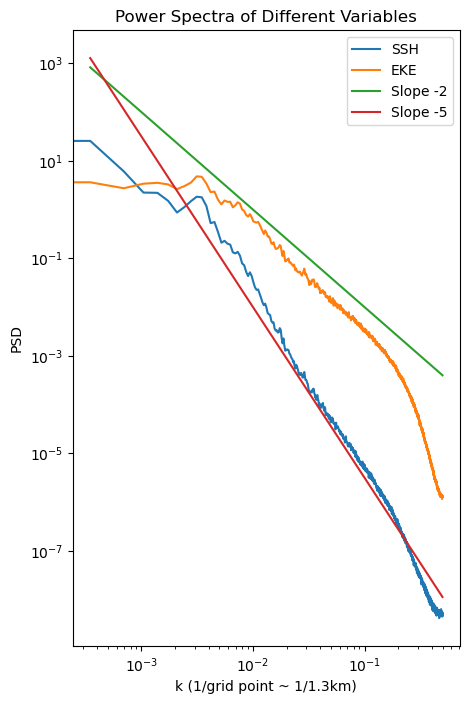

In [64]:
plt.figure(figsize=(5,8))

(ds_sel_loaded_k_ps.SSH_ps.mean('j')).plot(label='SSH')
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').plot(label='EKE')

# 添加两条斜率
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-4*ds_sel_loaded_k_ps.freq_i**-2, label='Slope -2')
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-9*ds_sel_loaded_k_ps.freq_i**-3.5, label='Slope -5')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')

plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.legend()
plt.title('Power Spectra of Different Variables')

Text(0.5, 1.0, 'Power Spectra of Different Variables')

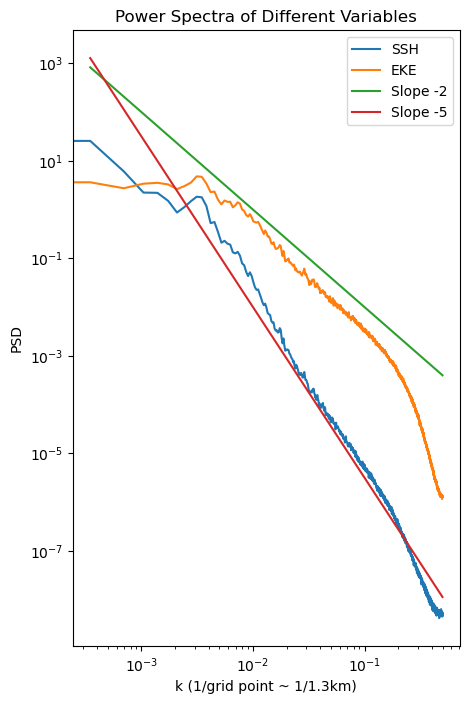

In [48]:
plt.figure(figsize=(5,8))

(ds_sel_loaded_k_ps.SSH_ps.mean('j')).plot(label='SSH')
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').plot(label='EKE')

# 添加两条斜率
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-4*ds_sel_loaded_k_ps.freq_i**-2, label='Slope -2')
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-9*ds_sel_loaded_k_ps.freq_i**-3.5, label='Slope -5')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')

plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.legend()
plt.title('Power Spectra of Different Variables')


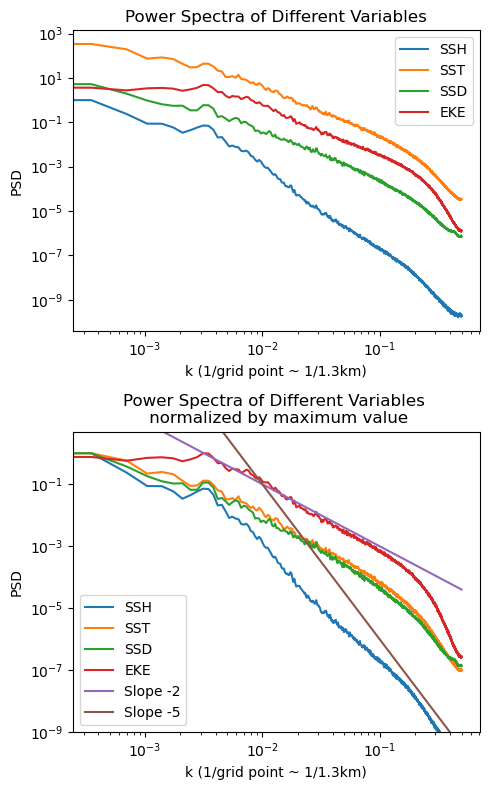

In [49]:
plt.figure(figsize=(5,8))

plt.subplot(211)

(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
ds_sel_loaded_k_ps.SST_ps.mean('j').plot(label='SST')
ds_sel_loaded_k_ps.SSD_ps.mean('j').plot(label='SSD')
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').plot(label='EKE')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.legend()
plt.title('Power Spectra of Different Variables')

plt.subplot(212)

(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
(ds_sel_loaded_k_ps.SST_ps.mean('j')/ds_sel_loaded_k_ps.SST_ps.mean('j').max()
        ).plot(label='SST')
(ds_sel_loaded_k_ps.SSD_ps.mean('j')/ds_sel_loaded_k_ps.SSD_ps.mean('j').max()
        ).plot(label='SSD')
((ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j')/
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').max()
    ).plot(label='EKE')

plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-5*ds_sel_loaded_k_ps.freq_i**-2, label='Slope -2')
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-11*ds_sel_loaded_k_ps.freq_i**-5, label='Slope -5')
plt.ylim([1e-9, 5])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.title('Power Spectra of Different Variables \n normalized by maximum value')
plt.legend()
plt.tight_layout()


In [65]:
ds_sel_loaded

<xarray.Dataset>
Dimensions:  (i: 2879, j: 2817)
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 -2.128 -2.13 -2.131 -2.131 ... 0.4445 0.4459 0.4475
    SST      (j, i) float32 -1.873 -1.873 -1.874 -1.874 ... 22.87 22.87 22.86
    SSS      (j, i) float32 34.21 34.21 34.21 34.21 ... 35.25 35.27 35.28 35.29
    U        (j, i) float32 -0.03118 -0.03053 -0.02989 ... -0.1109 -0.1127
    V        (j, i) float32 0.1712 0.1727 0.1742 ... -0.1241 -0.1059 -0.08785
    SSD      (j, i) float64 1.028e+03 1.028e+03 ... 1.024e+03 1.024e+03

In [50]:
# Wavenumber spectra, check how isotropic things are

SSH_ps_x = xrft.power_spectrum(ds_sel_loaded.Eta,
                             dim=['i'],
                             window=True, 
                             detrend='constant').compute()

SSH_ps_y = xrft.power_spectrum(ds_sel_loaded.Eta,
                             dim=['j'],
                             window=True, 
                             detrend='constant').compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [51]:
# since the dimensions are just grid point indices
# we need to rescale k axis
dx=1.3

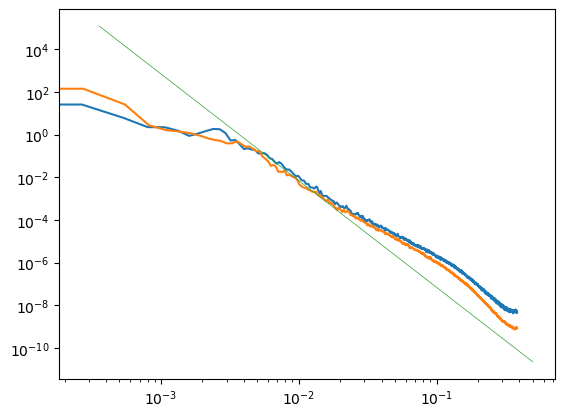

In [52]:
plt.plot(SSH_ps_x.freq_i/dx, SSH_ps_x.mean(['j']))
plt.plot(SSH_ps_y.freq_j/dx, SSH_ps_y.mean(['i']))
plt.plot(SSH_ps_y.freq_j, 0.7e-12*SSH_ps_y.freq_j**-5, linewidth=0.5)

plt.xscale('log')
plt.yscale('log')

### Frequency Spectra

In [53]:
SSH_sel

<xarray.DataArray 'Eta' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [54]:
arr = xr.DataArray(

    np.arange(6).reshape(2, 3),

    coords=[("x", ["a", "b"]), ("y", [0, 1, 2])],

)
arr

<xarray.DataArray (x: 2, y: 3)>
array([[0, 1, 2],
       [3, 4, 5]])
Coordinates:
  * x        (x) <U1 'a' 'b'
  * y        (y) int64 0 1 2

In [55]:
stacked = arr.stack(z=("x", "y"))
stacked

<xarray.DataArray (z: 6)>
array([0, 1, 2, 3, 4, 5])
Coordinates:
  * z        (z) object MultiIndex
  * x        (z) <U1 'a' 'a' 'a' 'b' 'b' 'b'
  * y        (z) int64 0 1 2 0 1 2

In [56]:
SSH_sel

<xarray.DataArray 'Eta' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [57]:
# Take a smaller subset of the data for the frequency spectra
# Here we take a much smaller subset because we have no expectations 
# of the frequency spectra to vary signficantly spatially

subset_factor = 30

SSH_sel_subset = (SSH_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,45*24)) # 45 days of data selected
                 .stack(point=['i','j'])
                 .chunk({'time': 15*24, 'point':544})
                 )

In [58]:
SSH_sel_subset

<xarray.DataArray 'Eta' (time: 1080, point: 9024)>
dask.array<rechunk-merge, shape=(1080, 9024), dtype=float32, chunksize=(360, 544), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-10-27T23:00:00
  * point    (point) object MultiIndex
  * i        (point) int64 1824 1824 1824 1824 1824 ... 4674 4674 4674 4674 4674
  * j        (point) int64 4040 4070 4100 4130 4160 ... 6710 6740 6770 6800 6830

In [59]:
subset_factor = 30
V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,45*24)) # 45 days of data selected
                 .stack(point=['i','j'])
                 .chunk({'time': 45*24, 'point':544})
               )
# V_sel_subset = (V_sel.isel(j=slice(1),
#                               i=slice(1), 
#                               time=slice(0,45*24)) # 45 days of data selected
#                  .stack(point=['i','j'])
#                  # .chunk({'time': 15*24, 'point':1})
#                )

In [60]:
V_sel_subset

<xarray.DataArray 'V' (time: 1080, point: 9024)>
dask.array<rechunk-merge, shape=(1080, 9024), dtype=float32, chunksize=(1080, 544), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-10-27T23:00:00
  * point    (point) object MultiIndex
  * i        (point) int64 1824 1824 1824 1824 1824 ... 4674 4674 4674 4674 4674
  * j        (point) int64 4040 4070 4100 4130 4160 ... 6710 6740 6770 6800 6830

In [61]:
# load the data set, since the selected subset is so small
# however, beware that this step can sometimes kill workers (sadly :( )
SSH_sel_subset.load();

[########################################] | 100% Completed | 400.11 s


In [92]:
V_sel_subset.load();

[########################################] | 100% Completed | 12min 42.2s


In [141]:
# V_sel_subset.values

In [85]:
SSH_ps_t = xrft.power_spectrum(SSH_sel_subset, dim=['time'],
                           window=True, detrend='constant')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [88]:
SSH_ps_t

<xarray.DataArray (freq_time: 1080, point: 9024)>
array([[4.68415705e-06, 2.25190410e-07, 6.61223517e-05, ...,
        7.39083947e-05, 2.80367480e-02, 1.18504966e-02],
       [3.92980418e-07, 2.82382010e-05, 1.12148048e-05, ...,
        7.29206160e-03, 2.10070908e-02, 2.09065254e-02],
       [1.28643367e-06, 1.11682635e-04, 1.87351386e-05, ...,
        7.94754267e-03, 1.88197117e-02, 2.98900071e-02],
       ...,
       [1.75427621e-05, 8.05226319e-05, 4.92174077e-06, ...,
        7.00219375e-03, 2.06351739e-02, 1.69216742e-02],
       [1.28643367e-06, 1.11682635e-04, 1.87351386e-05, ...,
        7.94754267e-03, 1.88197117e-02, 2.98900071e-02],
       [3.92980418e-07, 2.82382010e-05, 1.12148048e-05, ...,
        7.29206160e-03, 2.10070908e-02, 2.09065254e-02]])
Coordinates:
  * point      (point) MultiIndex
  - i          (point) int64 1824 1824 1824 1824 1824 ... 4674 4674 4674 4674
  - j          (point) int64 4040 4070 4100 4130 4160 ... 6740 6770 6800 6830
  * freq_time  (freq_time) float64 -0.0001389 -0.0001386 ... 0.0001384 0.0001386

In [94]:
V_ps_t = xrft.power_spectrum(V_sel_subset, dim=['time'],
                           window=True, detrend='constant')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [95]:
V_ps_t

<xarray.DataArray (freq_time: 1080, point: 9024)>
array([[1.52054649e-05, 1.80919102e-05, 6.91912962e-04, ...,
        7.58560556e-03, 5.30086921e-03, 2.49633491e-02],
       [2.27218239e-04, 2.87059783e-04, 8.13964384e-04, ...,
        2.08358083e-02, 5.48275703e-03, 1.59077174e-02],
       [2.30660235e-04, 3.84252700e-04, 1.17219158e-03, ...,
        4.29424566e-03, 2.05469680e-02, 4.35449055e-02],
       ...,
       [7.24294863e-05, 1.33430872e-04, 9.74269341e-04, ...,
        3.07013186e-02, 7.84417060e-02, 2.14422165e-02],
       [2.30660235e-04, 3.84252700e-04, 1.17219158e-03, ...,
        4.29424566e-03, 2.05469680e-02, 4.35449055e-02],
       [2.27218239e-04, 2.87059783e-04, 8.13964384e-04, ...,
        2.08358083e-02, 5.48275703e-03, 1.59077174e-02]])
Coordinates:
  * point      (point) MultiIndex
  - i          (point) int64 1824 1824 1824 1824 1824 ... 4674 4674 4674 4674
  - j          (point) int64 4040 4070 4100 4130 4160 ... 6740 6770 6800 6830
  * freq_time  (freq_time) float64 -0.0001389 -0.0001386 ... 0.0001384 0.0001386

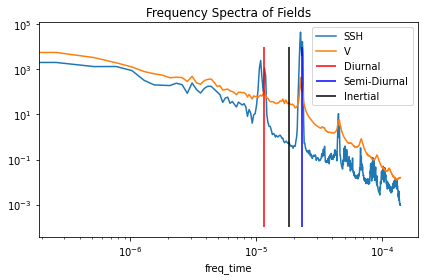

In [96]:
f = 2*2*np.pi/24/3600*np.sin(-52*np.pi/180)

SSH_ps_t.mean(['point']).plot(label='SSH')
V_ps_t.mean(['point']).plot(label='V')

plt.vlines([1/86400], 1e-4, 1e4, label='Diurnal', colors='r')
plt.vlines([1/43200], 1e-4, 1e4, label='Semi-Diurnal', colors='b')
plt.vlines([ -f/2/np.pi], 1e-4, 1e4, label='Inertial', colors='k')

plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.title('Frequency Spectra of Fields')

plt.tight_layout()

In [97]:
SSH_sel

<xarray.DataArray 'Eta' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

[########################################] | 100% Completed | 21.4s


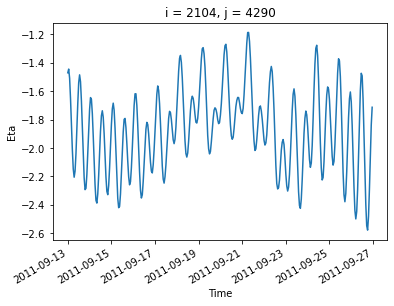

In [98]:
# Plot a short time series surface map
SSH_sel.isel(i=280, j=250).isel(time=slice(0,14*24)).plot()

### Freq-wavenumber Spectra

In [102]:
# 120天，
V_sub_sel = (V_sel.isel(time=slice(0,120*24), i=slice(0,480), j=slice(0,494,10))
             .chunk({'time':480, 'i':120, 'j':10})
            )


In [103]:
V_sub_sel

<xarray.DataArray 'V' (time: 2880, j: 50, i: 480)>
dask.array<rechunk-merge, shape=(2880, 50, 480), dtype=float32, chunksize=(480, 10, 120), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 2299 2300 2301 2302 2303
  * j        (j) int64 4040 4050 4060 4070 4080 ... 4490 4500 4510 4520 4530
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-01-10T23:00:00

In [120]:
V_sub_sel_ps_xt =  xrft.power_spectrum(V_sub_sel, dim=['time','i'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [121]:
V_sub_sel_ps_xt

<xarray.DataArray 'rechunk-merge-2839b70e3bceb2c1b49b39582dd2374f' (
                                                                    time_segment: 6,
                                                                    freq_time: 480,
                                                                    j: 50,
                                                                    i_segment: 4,
                                                                    freq_i: 120)>
dask.array<mul, shape=(6, 480, 50, 4, 120), dtype=float64, chunksize=(1, 480, 10, 1, 120), chunktype=numpy.ndarray>
Coordinates:
  * time_segment  (time_segment) int64 0 1 2 3 4 5
  * j             (j) int64 4040 4050 4060 4070 4080 ... 4500 4510 4520 4530
  * i_segment     (i_segment) int64 0 1 2 3
  * freq_time     (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * freq_i        (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.475 0.4833 0.4917

In [122]:
V_sub_sel_ps_xt_av =V_sub_sel_ps_xt.mean(dim=['time_segment', 'i_segment','j'])

In [123]:
V_sub_sel_ps_xt_av

<xarray.DataArray 'rechunk-merge-2839b70e3bceb2c1b49b39582dd2374f' (
                                                                    freq_time: 480,
                                                                    freq_i: 120)>
dask.array<mean_agg-aggregate, shape=(480, 120), dtype=float64, chunksize=(480, 120), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001377 0.0001383
  * freq_i     (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.475 0.4833 0.4917

In [124]:
V_sub_sel_ps_xt_av_p = V_sub_sel_ps_xt_av.persist(retries=10)

[########################################] | 100% Completed | 18min 38.6s


In [129]:
V_sub_sel_ps_xt_av

<xarray.DataArray 'rechunk-merge-2839b70e3bceb2c1b49b39582dd2374f' (
                                                                    freq_time: 480,
                                                                    freq_i: 120)>
dask.array<mean_agg-aggregate, shape=(480, 120), dtype=float64, chunksize=(480, 120), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001377 0.0001383
  * freq_i     (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.475 0.4833 0.4917

In [126]:
V_sub_sel_ps_xt_av_p

<xarray.DataArray 'rechunk-merge-2839b70e3bceb2c1b49b39582dd2374f' (
                                                                    freq_time: 480,
                                                                    freq_i: 120)>
dask.array<mean_agg-aggregate, shape=(480, 120), dtype=float64, chunksize=(480, 120), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001377 0.0001383
  * freq_i     (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.475 0.4833 0.4917

In [127]:
from dask_gateway import GatewayCluster
from dask.distributed import Client
cluster = GatewayCluster()
cluster.scale(5)
client = Client(cluster)
cluster

In [128]:
# cluster.shutdown()

In [131]:
%time V_sub_sel_ps_xt_av_p.load()

[########################################] | 100% Completed |  0.1s
CPU times: user 5.6 ms, sys: 6.1 ms, total: 11.7 ms
Wall time: 106 ms


<xarray.DataArray 'rechunk-merge-2839b70e3bceb2c1b49b39582dd2374f' (
                                                                    freq_time: 480,
                                                                    freq_i: 120)>
array([[1.48636934e-05, 1.34270532e-05, 1.32433795e-05, ...,
        1.39609624e-05, 1.32433795e-05, 1.34270532e-05],
       [1.40181432e-05, 1.38106481e-05, 1.41771090e-05, ...,
        1.35413515e-05, 1.23579620e-05, 1.39947551e-05],
       [1.30837967e-05, 1.35587155e-05, 1.32841138e-05, ...,
        1.42366240e-05, 1.34230348e-05, 1.34497048e-05],
       ...,
       [1.34749390e-05, 1.35368605e-05, 1.30977263e-05, ...,
        1.13464530e-05, 1.20916202e-05, 1.38387157e-05],
       [1.30837967e-05, 1.34497048e-05, 1.34230348e-05, ...,
        1.18187977e-05, 1.32841138e-05, 1.35587155e-05],
       [1.40181432e-05, 1.39947551e-05, 1.23579620e-05, ...,
        1.39962452e-05, 1.41771090e-05, 1.38106481e-05]])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001377 0.0001383
  * freq_i     (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.475 0.4833 0.4917

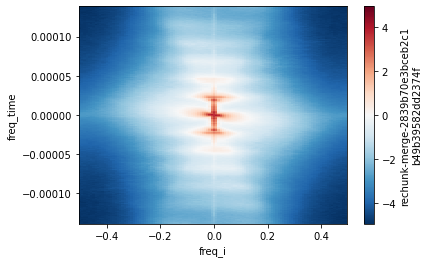

In [154]:
np.log10(V_sub_sel_ps_xt_av_p).plot(x='freq_i')

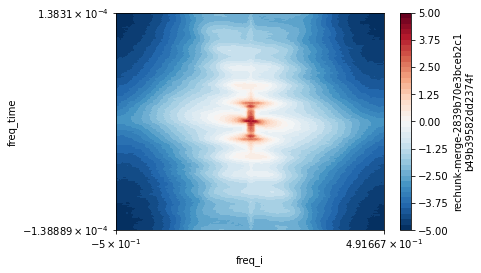

In [167]:
np.log10(V_sub_sel_ps_xt_av_p).plot.contourf(xscale='symlog',yscale='symlog',levels=50)

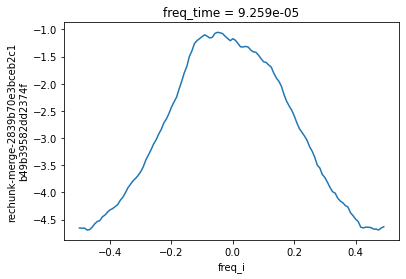

In [170]:
np.log10(V_sub_sel_ps_xt_av_p.isel(freq_time=400)).plot(x='freq_i')

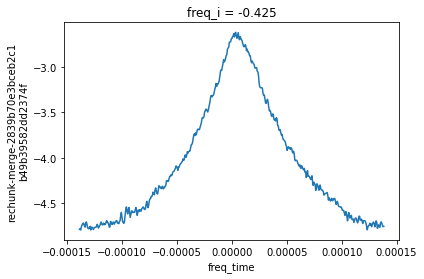

In [172]:
np.log10(V_sub_sel_ps_xt_av_p.isel(freq_i=9)).plot(x='freq_time')

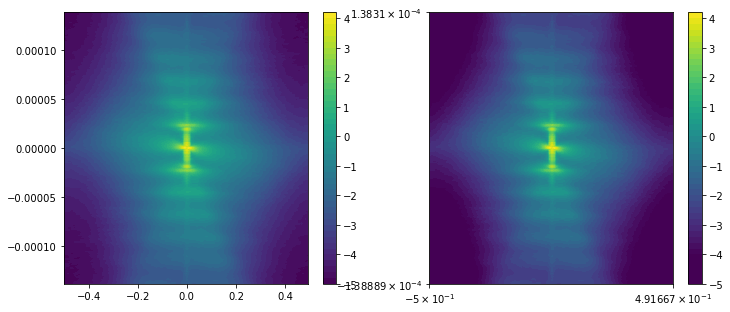

In [151]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=50 )
#plt.xscale('symlog', linthreshx=1e-2)
#plt.yscale('symlog', linthreshy=1e-6)
plt.colorbar()

plt.subplot(122)
# plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
#              np.log10(V_sub_sel_ps_xt_av_p), levels=50 , vmin=-4)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=50 , vmin=-4)
# plt.xscale('symlog', linthreshx=5e-2)
# plt.yscale('symlog', linthreshy=5e-6) 
plt.xscale('symlog')
plt.yscale('symlog')
plt.colorbar()
plt.grid(True)
# plt.xlim([-1 , 1])
# plt.ylim([-1e-4 , 1e-4])

### Rotary Spectra
- Velocity

In [197]:
subset_factor = 80

In [193]:
U_sel

<xarray.DataArray 'U' (time: 9030, j: 2817, i: 2879)>
dask.array<getitem, shape=(9030, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [198]:
U_sel_subset = (U_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':1000}))

V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':500}))

In [199]:
V_sel_subset

<xarray.DataArray 'V' (time: 1440, point: 1296)>
dask.array<rechunk-merge, shape=(1440, 1296), dtype=float32, chunksize=(480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-11T23:00:00
  * point    (point) MultiIndex
  - i        (point) int64 1824 1824 1824 1824 1824 ... 4624 4624 4624 4624 4624
  - j        (point) int64 4040 4120 4200 4280 4360 ... 6520 6600 6680 6760 6840

In [200]:
Z_sel_subset = U_sel_subset + 1j*V_sel_subset # python里1j是一个特殊符号代表-1的平方根

In [201]:
Z_sel_subset

<xarray.DataArray (time: 1440, point: 1296)>
dask.array<add, shape=(1440, 1296), dtype=complex64, chunksize=(480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-11T23:00:00
  * point    (point) MultiIndex
  - i        (point) int64 1824 1824 1824 1824 1824 ... 4624 4624 4624 4624 4624
  - j        (point) int64 4040 4120 4200 4280 4360 ... 6520 6600 6680 6760 6840

In [202]:
Z_ps_t = xrft.power_spectrum(Z_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)
Z_ps_t

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray 'rechunk-merge-fa9526b27e2696bd8dc5d3af7cc9e99e' (
                                                                    time_segment: 3,
                                                                    freq_time: 480,
                                                                    point: 1296)>
dask.array<mul, shape=(3, 480, 1296), dtype=float64, chunksize=(1, 480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_segment  (time_segment) int64 0 1 2
  * point         (point) object (1824, 4040) (1824, 4120) ... (4624, 6840)
  * freq_time     (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383

In [203]:
Z_ps_t_av = Z_ps_t.mean(dim=['time_segment', 'point'])

In [204]:
%time Z_ps_t_av_p = Z_ps_t_av.persist(retries=10)

[########################################] | 100% Completed | 38min 40.6s
CPU times: user 1h 17min 25s, sys: 42min 55s, total: 2h 21s
Wall time: 38min 55s


In [207]:
Z_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-fa9526b27e2696bd8dc5d3af7cc9e99e' (
                                                                    freq_time: 480)>
array([3.05762806e-02, 3.14434735e-02, 2.99417530e-02, 2.91089719e-02,
       2.94108060e-02, 2.99780138e-02, 2.98040147e-02, 2.80188216e-02,
       2.65946348e-02, 2.55539593e-02, 2.58716926e-02, 2.38423198e-02,
       2.36971510e-02, 2.55447099e-02, 2.63321143e-02, 2.50156677e-02,
       2.45895429e-02, 2.39565023e-02, 2.38389081e-02, 2.34537205e-02,
       2.51202941e-02, 2.62953211e-02, 2.53229293e-02, 2.64659909e-02,
       2.86706049e-02, 2.97429652e-02, 2.97459902e-02, 3.12162706e-02,
       3.12995932e-02, 3.02166500e-02, 2.98375667e-02, 3.09457401e-02,
       3.31369304e-02, 3.42939744e-02, 3.61608922e-02, 3.86468374e-02,
       3.88219911e-02, 4.08894890e-02, 4.35176914e-02, 4.65345677e-02,
       5.22018513e-02, 5.21868174e-02, 5.58217375e-02, 5.79262660e-02,
       5.94574603e-02, 6.10461932e-02, 6.27064850e-02, 6.15513210e-02,
       5.67101070e-02, 4.91921143e-02, 4.94997646e-02, 4.79812569e-02,
       4.86360907e-02, 4.93001925e-02, 4.85141673e-02, 4.66234503e-02,
       4.45138284e-02, 4.44540731e-02, 4.53009313e-02, 5.13264939e-02,
       5.79711319e-02, 6.11915242e-02, 5.78314378e-02, 5.80869439e-02,
       6.10156468e-02, 6.46462892e-02, 6.28148391e-02, 6.37255345e-02,
       6.28224799e-02, 6.70192199e-02, 6.98897179e-02, 6.88307622e-02,
       7.45124731e-02, 7.95540573e-02, 8.82494504e-02, 9.50377218e-02,
       9.91863431e-02, 1.16722623e-01, 1.40455572e-01, 1.47047744e-01,
...
       2.73349567e-01, 2.38632055e-01, 2.11961486e-01, 1.93088621e-01,
       1.69539381e-01, 1.47636797e-01, 1.44367524e-01, 1.37183609e-01,
       1.30740371e-01, 1.16204839e-01, 1.10507481e-01, 1.05372844e-01,
       1.03870773e-01, 1.01308124e-01, 9.78010707e-02, 9.92503132e-02,
       9.72353721e-02, 9.29206860e-02, 8.67892452e-02, 8.19498000e-02,
       7.73932815e-02, 7.76380731e-02, 7.79837126e-02, 7.26037597e-02,
       6.98399603e-02, 7.22074999e-02, 7.34140564e-02, 7.08247819e-02,
       7.26567810e-02, 7.25827565e-02, 7.26901967e-02, 7.56356052e-02,
       8.02758818e-02, 8.58457148e-02, 9.15958536e-02, 9.21493702e-02,
       9.10292106e-02, 8.55985241e-02, 7.72864288e-02, 7.34534620e-02,
       7.10136443e-02, 6.25886066e-02, 5.53377770e-02, 5.46839855e-02,
       5.11952732e-02, 4.94014046e-02, 5.06699567e-02, 4.86557317e-02,
       4.61770674e-02, 4.23235969e-02, 4.08964281e-02, 4.00225343e-02,
       3.73469733e-02, 3.58018473e-02, 3.34239980e-02, 3.31085283e-02,
       3.26570979e-02, 3.25864783e-02, 3.07570480e-02, 3.13428882e-02,
       3.20298912e-02, 3.18008633e-02, 2.90487767e-02, 2.70520488e-02,
       2.71195279e-02, 2.79280456e-02, 2.82305906e-02, 2.73679299e-02,
       2.77560323e-02, 2.75513577e-02, 2.82990251e-02, 2.80505470e-02,
       2.94862890e-02, 3.17238848e-02, 3.14998541e-02, 3.14016068e-02,
       3.07507090e-02, 2.97054211e-02, 3.03622957e-02, 3.13377854e-02])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001377 0.0001383

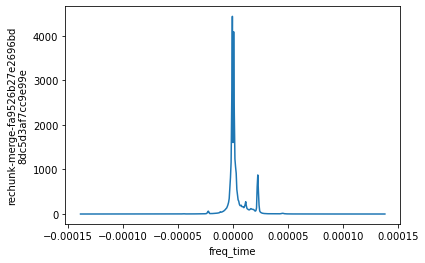

In [209]:
Z_ps_t_av_p.plot()

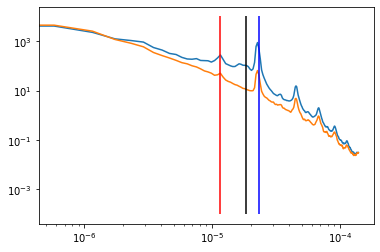

In [214]:
plt.plot(Z_ps_t_av_p.freq_time, Z_ps_t_av_p)
plt.plot(-Z_ps_t_av_p.freq_time, Z_ps_t_av_p)
# plt.plot(-Z_ps_t_av_p.freq_time, Z_ps_t_av_p)
plt.vlines([1/86400, 1/43200, -f/2/np.pi], 1e-4, 1e4, 
           colors=['r','b','k'])
plt.xscale('log')
plt.yscale('log')